In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

### Load and Prepare Data

In [18]:
df = pd.read_csv("data_ggl.csv")

# Prepare features and target
X = df.drop(['Days', 'TMP_cmHg'], axis=1)
y = df['TMP_cmHg']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {list(X.columns)}")

# Train-test split (temporal split recommended for time series)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Features shape: (50, 16)
Target shape: (50,)
Features: ['pH_Influent', 'pH_Anoxic', 'pH_MBR', 'pH_Effluent', 'Alkalinity_Influent_mgCaCO3_L', 'Alkalinity_Anoxic_mgCaCO3_L', 'Alkalinity_MBR_mgCaCO3_L', 'Alkalinity_Effluent_mgCaCO3_L', 'Nitrate_Influent_mg_L', 'Nitrate_Anoxic_mg_L', 'Nitrate_MBR_mg_L', 'Nitrate_Effluent_mg_L', 'Ammonium_Influent_mg_L', 'Ammonium_Anoxic_mg_L', 'Ammonium_MBR_mg_L', 'Ammonium_Effluent_mg_L']

Train set: 40 samples
Test set: 10 samples


In [19]:
# Store all results
all_results = []

### HELPER FUNCTIONS

In [20]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model and return metrics"""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        'Model': model_name,
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    }
    
    return metrics, y_train_pred, y_test_pred

def plot_model_results(y_train, y_test, y_train_pred, y_test_pred, model_name, metrics, model_number):
    """Create comprehensive visualization for each model"""
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Main title
    fig.suptitle(f'Model {model_number}: {model_name} - Comprehensive Results', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # 1. Actual vs Predicted - Train
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(y_train, y_train_pred, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
    ax1.set_xlabel('Actual TMP (cmHg)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Predicted TMP (cmHg)', fontsize=11, fontweight='bold')
    ax1.set_title('Training Set: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.text(0.05, 0.95, f"R² = {metrics['Train_R2']:.4f}\nRMSE = {metrics['Train_RMSE']:.4f}", 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)
    
    # 2. Actual vs Predicted - Test
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(y_test, y_test_pred, alpha=0.6, s=100, edgecolors='black', linewidth=0.5, color='orange')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
    ax2.set_xlabel('Actual TMP (cmHg)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Predicted TMP (cmHg)', fontsize=11, fontweight='bold')
    ax2.set_title('Test Set: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.text(0.05, 0.95, f"R² = {metrics['Test_R2']:.4f}\nRMSE = {metrics['Test_RMSE']:.4f}", 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8), fontsize=10)
    
    # 3. Residuals - Train
    ax3 = fig.add_subplot(gs[0, 2])
    residuals_train = y_train - y_train_pred
    ax3.scatter(y_train_pred, residuals_train, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax3.set_xlabel('Predicted TMP (cmHg)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Residuals', fontsize=11, fontweight='bold')
    ax3.set_title('Training Set: Residual Plot', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Residuals - Test
    ax4 = fig.add_subplot(gs[1, 0])
    residuals_test = y_test - y_test_pred
    ax4.scatter(y_test_pred, residuals_test, alpha=0.6, s=100, edgecolors='black', 
                linewidth=0.5, color='orange')
    ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax4.set_xlabel('Predicted TMP (cmHg)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Residuals', fontsize=11, fontweight='bold')
    ax4.set_title('Test Set: Residual Plot', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Residuals Distribution - Train
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(residuals_train, bins=20, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax5.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax5.set_xlabel('Residuals', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax5.set_title('Training Set: Residual Distribution', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Residuals Distribution - Test
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.hist(residuals_test, bins=15, alpha=0.7, edgecolor='black', linewidth=0.5, color='orange')
    ax6.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax6.set_xlabel('Residuals', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax6.set_title('Test Set: Residual Distribution', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Time Series Plot - Combined
    ax7 = fig.add_subplot(gs[2, :])
    train_indices = range(len(y_train))
    test_indices = range(len(y_train), len(y_train) + len(y_test))
    
    ax7.plot(train_indices, y_train.values, 'o-', label='Actual (Train)', 
             linewidth=2, markersize=6, alpha=0.7)
    ax7.plot(train_indices, y_train_pred, 's--', label='Predicted (Train)', 
             linewidth=2, markersize=5, alpha=0.7)
    ax7.plot(test_indices, y_test.values, 'o-', label='Actual (Test)', 
             linewidth=2, markersize=6, alpha=0.7)
    ax7.plot(test_indices, y_test_pred, 's--', label='Predicted (Test)', 
             linewidth=2, markersize=5, alpha=0.7)
    ax7.axvline(x=len(y_train)-0.5, color='red', linestyle=':', linewidth=2, 
                label='Train/Test Split')
    ax7.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax7.set_ylabel('TMP (cmHg)', fontsize=12, fontweight='bold')
    ax7.set_title('Time Series: Actual vs Predicted Values', fontsize=13, fontweight='bold')
    ax7.legend(loc='upper left', fontsize=10)
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    filename = f'model_{model_number:02d}_{model_name.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Plot saved: {filename}")

### MODEL 1: LINEAR REGRESSION


Train R² Score: 0.8071
Test R² Score: 0.0000
Train RMSE: 0.3201
Test RMSE: 0.3873
Train MAE: 0.2349
Test MAE: 0.3127


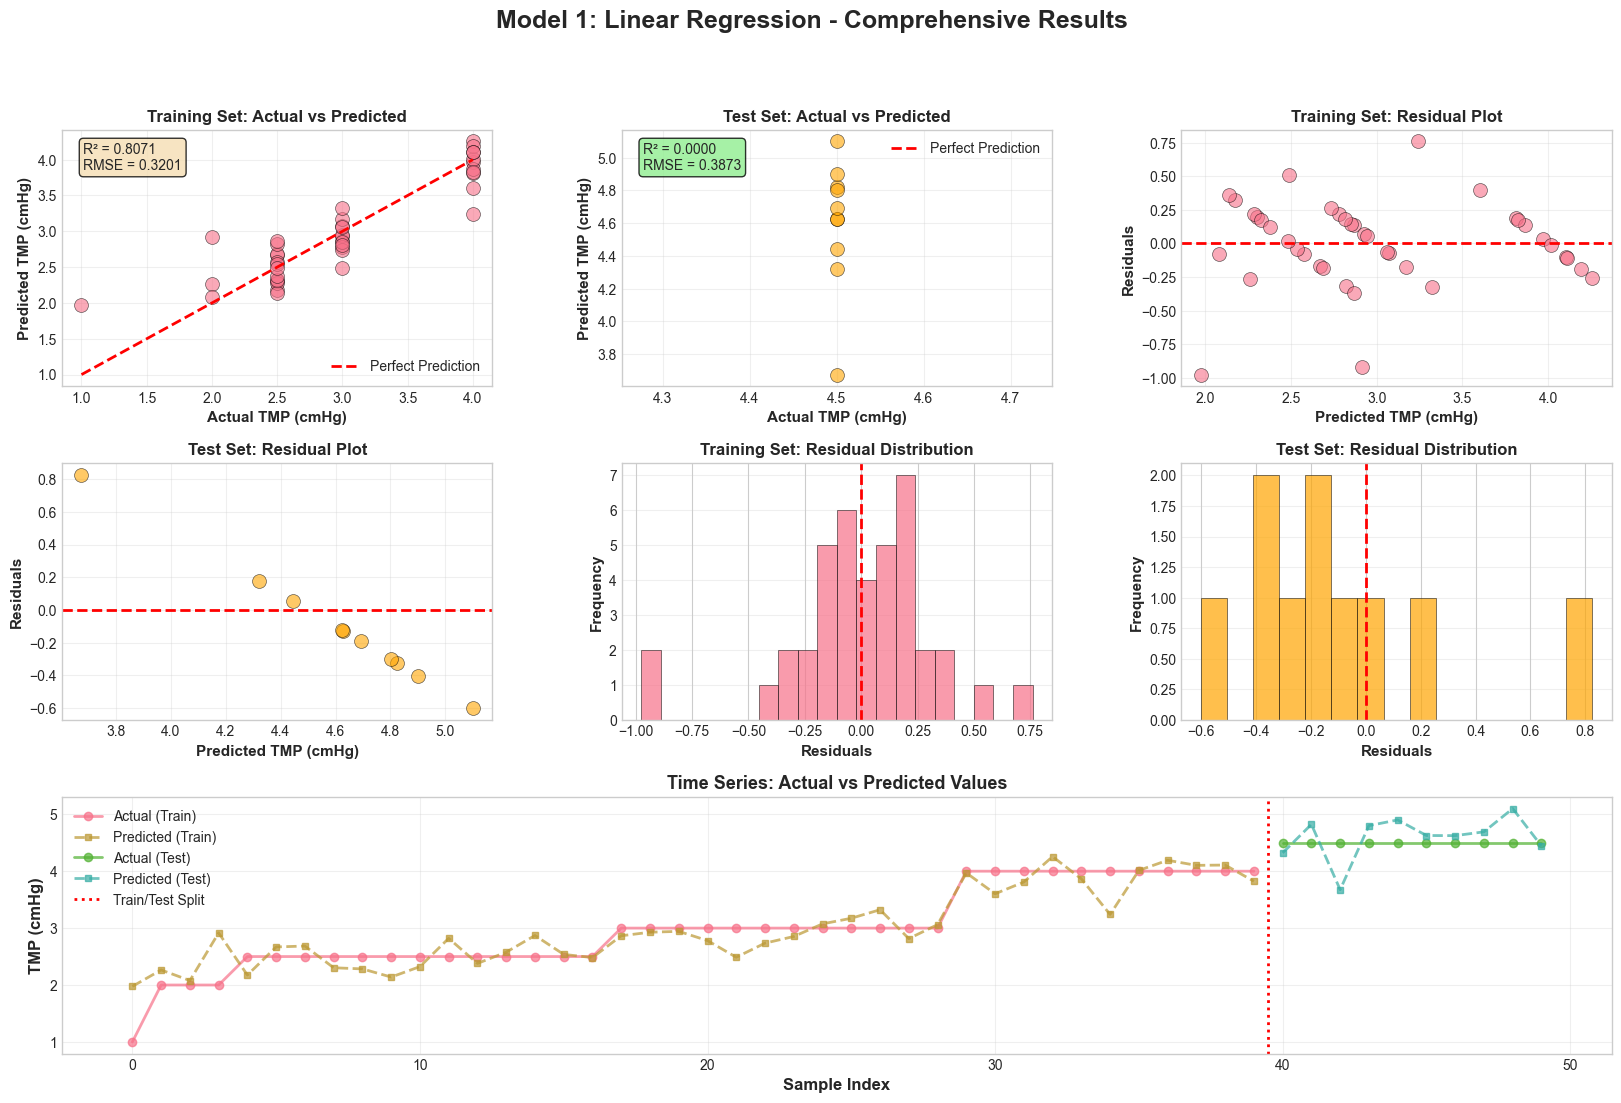

✓ Plot saved: model_01_Linear_Regression.png


In [21]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

metrics_lr, y_train_pred_lr, y_test_pred_lr = evaluate_model(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Linear Regression'
)

print(f"\nTrain R² Score: {metrics_lr['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_lr['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_lr['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_lr['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_lr['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_lr['Test_MAE']:.4f}")

all_results.append(metrics_lr)

plot_model_results(y_train, y_test, y_train_pred_lr, y_test_pred_lr, 
                   'Linear Regression', metrics_lr, 1)

### MODEL 2: POLYNOMIAL REGRESSION (Degree 2)


Train R² Score: 0.9999
Test R² Score: 0.0000
Train RMSE: 0.0087
Test RMSE: 0.7409
Train MAE: 0.0053
Test MAE: 0.6525


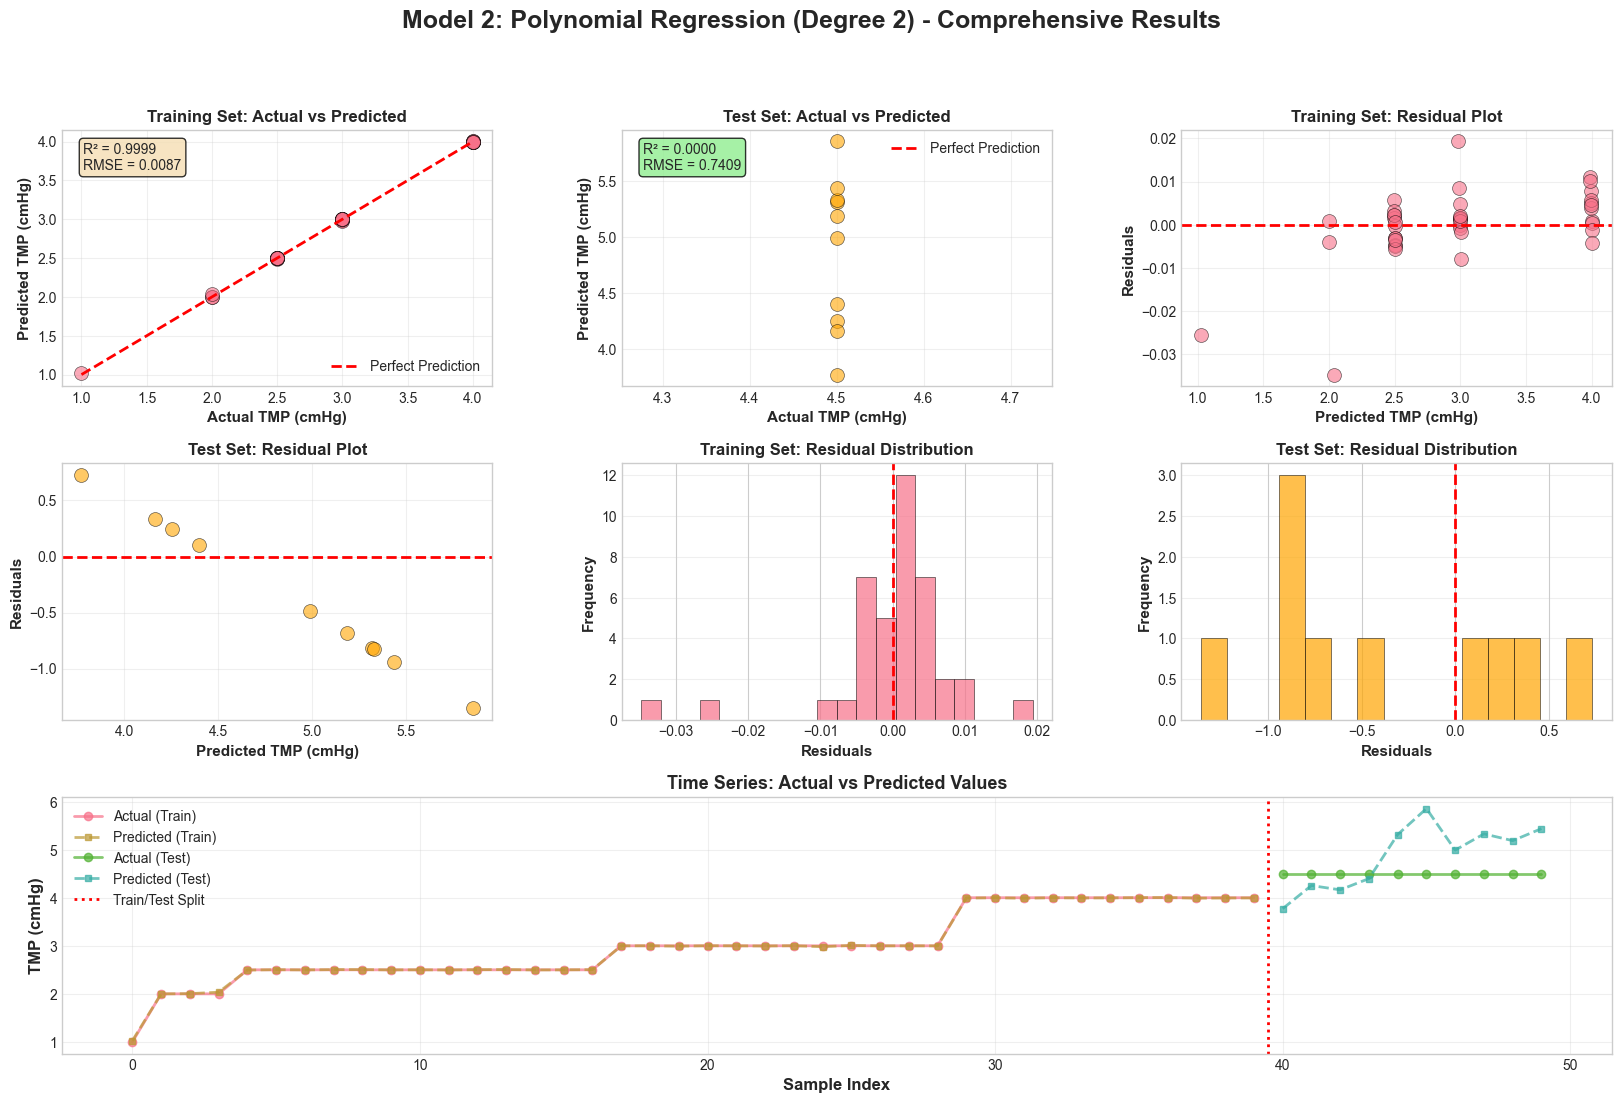

✓ Plot saved: model_02_Polynomial_Regression_(Degree_2).png


In [22]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_model = Ridge(alpha=1.0)  # Using Ridge to prevent overfitting
poly_model.fit(X_train_poly, y_train)

metrics_poly, y_train_pred_poly, y_test_pred_poly = evaluate_model(
    poly_model, X_train_poly, X_test_poly, y_train, y_test, 'Polynomial Regression'
)

print(f"\nTrain R² Score: {metrics_poly['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_poly['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_poly['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_poly['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_poly['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_poly['Test_MAE']:.4f}")

all_results.append(metrics_poly)

plot_model_results(y_train, y_test, y_train_pred_poly, y_test_pred_poly, 
                   'Polynomial Regression (Degree 2)', metrics_poly, 2)

### MODEL 3: SUPPORT VECTOR MACHINE (SVM)


Train R² Score: 0.9828
Test R² Score: 0.0000
Train RMSE: 0.0956
Test RMSE: 0.8729
Train MAE: 0.0943
Test MAE: 0.8644


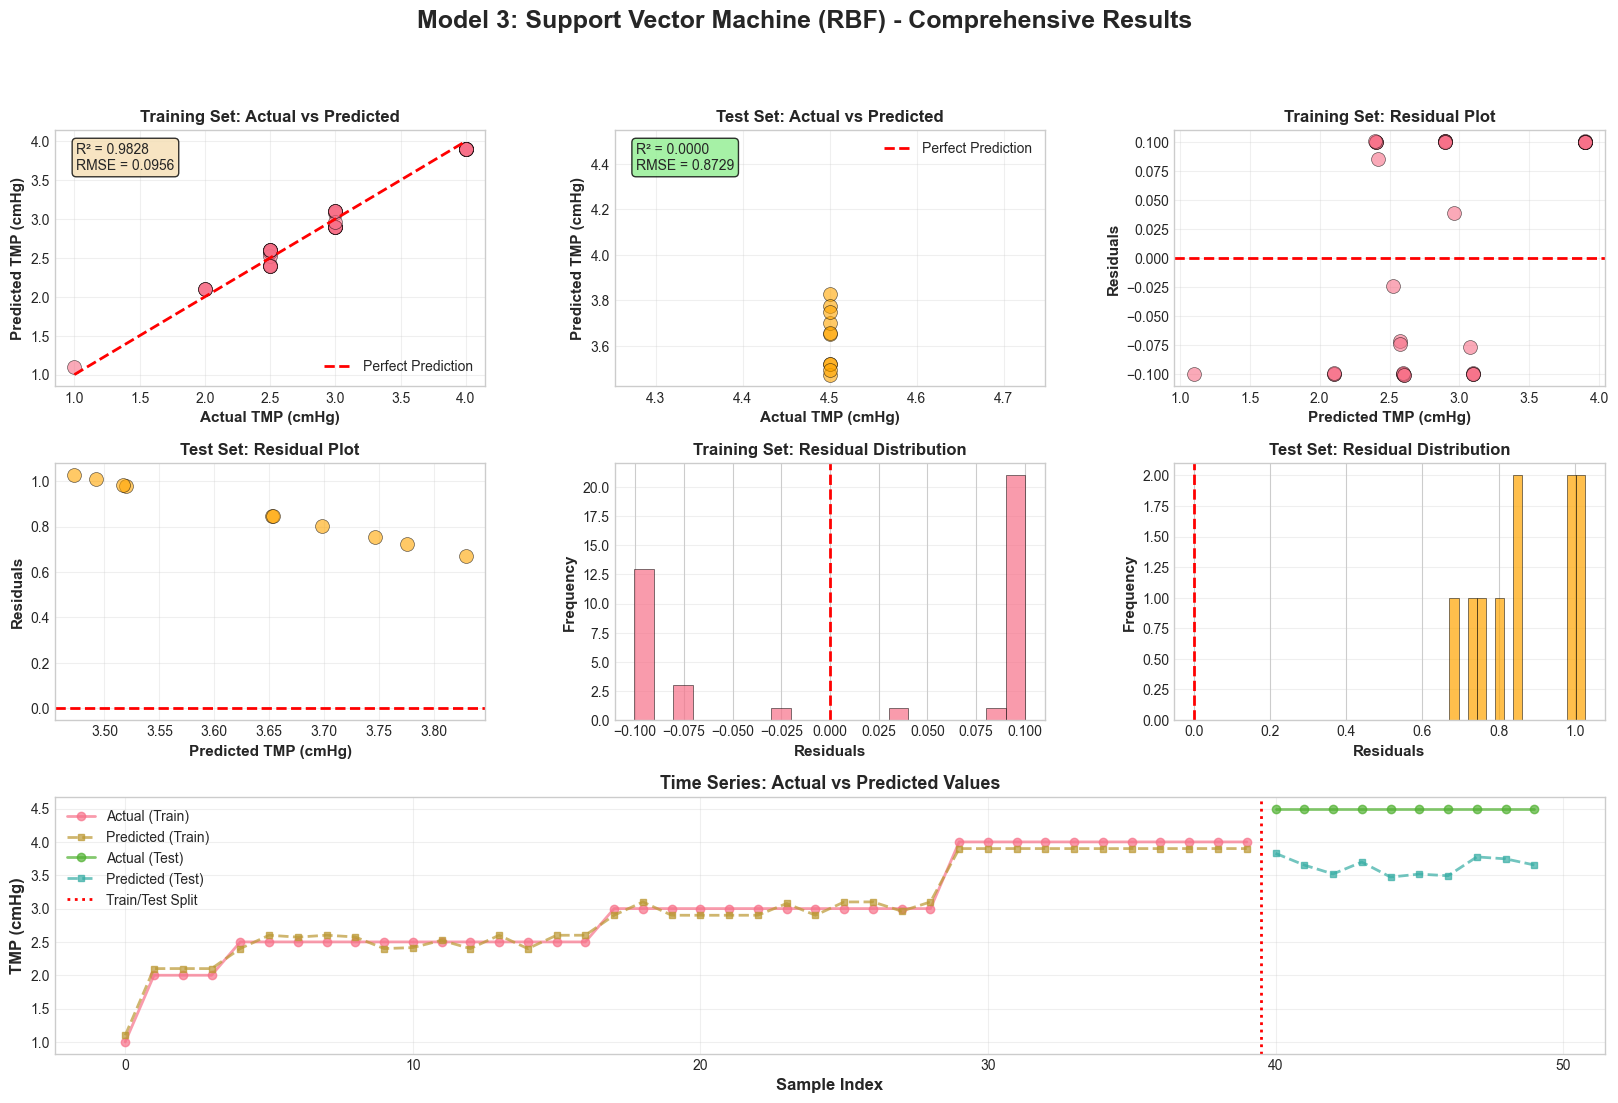

✓ Plot saved: model_03_Support_Vector_Machine_(RBF).png


In [23]:


svm_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)

metrics_svm, y_train_pred_svm, y_test_pred_svm = evaluate_model(
    svm_model, X_train_scaled, X_test_scaled, y_train, y_test, 'SVM'
)

print(f"\nTrain R² Score: {metrics_svm['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_svm['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_svm['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_svm['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_svm['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_svm['Test_MAE']:.4f}")

all_results.append(metrics_svm)

plot_model_results(y_train, y_test, y_train_pred_svm, y_test_pred_svm, 
                   'Support Vector Machine (RBF)', metrics_svm, 3)

### MODEL 4: RANDOM FOREST


Train R² Score: 0.9025
Test R² Score: 0.0000
Train RMSE: 0.2275
Test RMSE: 0.6380
Train MAE: 0.1485
Test MAE: 0.6327

Top 5 Important Features:
                  feature  importance
10       Nitrate_MBR_mg_L    0.716291
1               pH_Anoxic    0.053851
13   Ammonium_Anoxic_mg_L    0.045927
9     Nitrate_Anoxic_mg_L    0.045869
11  Nitrate_Effluent_mg_L    0.034842


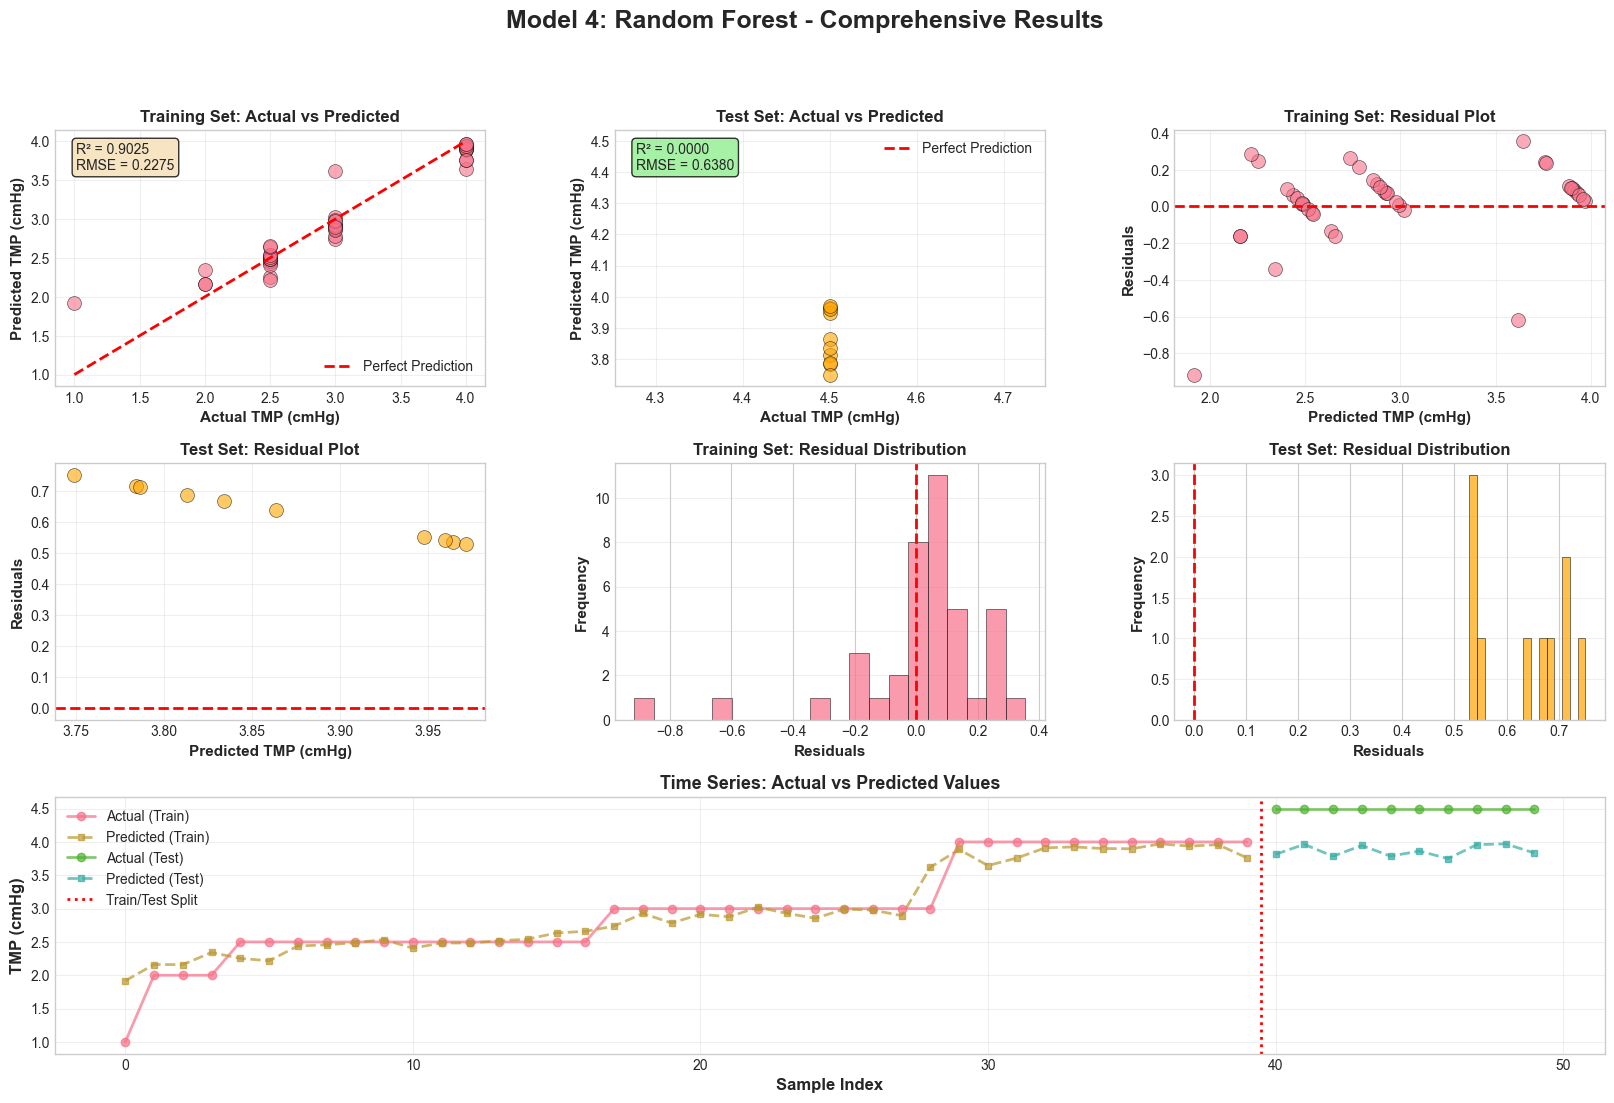

✓ Plot saved: model_04_Random_Forest.png


In [24]:


rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, 
                                  min_samples_split=5, min_samples_leaf=2,
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

metrics_rf, y_train_pred_rf, y_test_pred_rf = evaluate_model(
    rf_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Random Forest'
)

print(f"\nTrain R² Score: {metrics_rf['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_rf['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_rf['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_rf['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_rf['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_rf['Test_MAE']:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 5 Important Features:")
print(feature_importance.head())

all_results.append(metrics_rf)

plot_model_results(y_train, y_test, y_train_pred_rf, y_test_pred_rf, 
                   'Random Forest', metrics_rf, 4)

### MODEL 5: EXTRA TREES


Train R² Score: 0.9451
Test R² Score: 0.0000
Train RMSE: 0.1707
Test RMSE: 0.7614
Train MAE: 0.1010
Test MAE: 0.7450


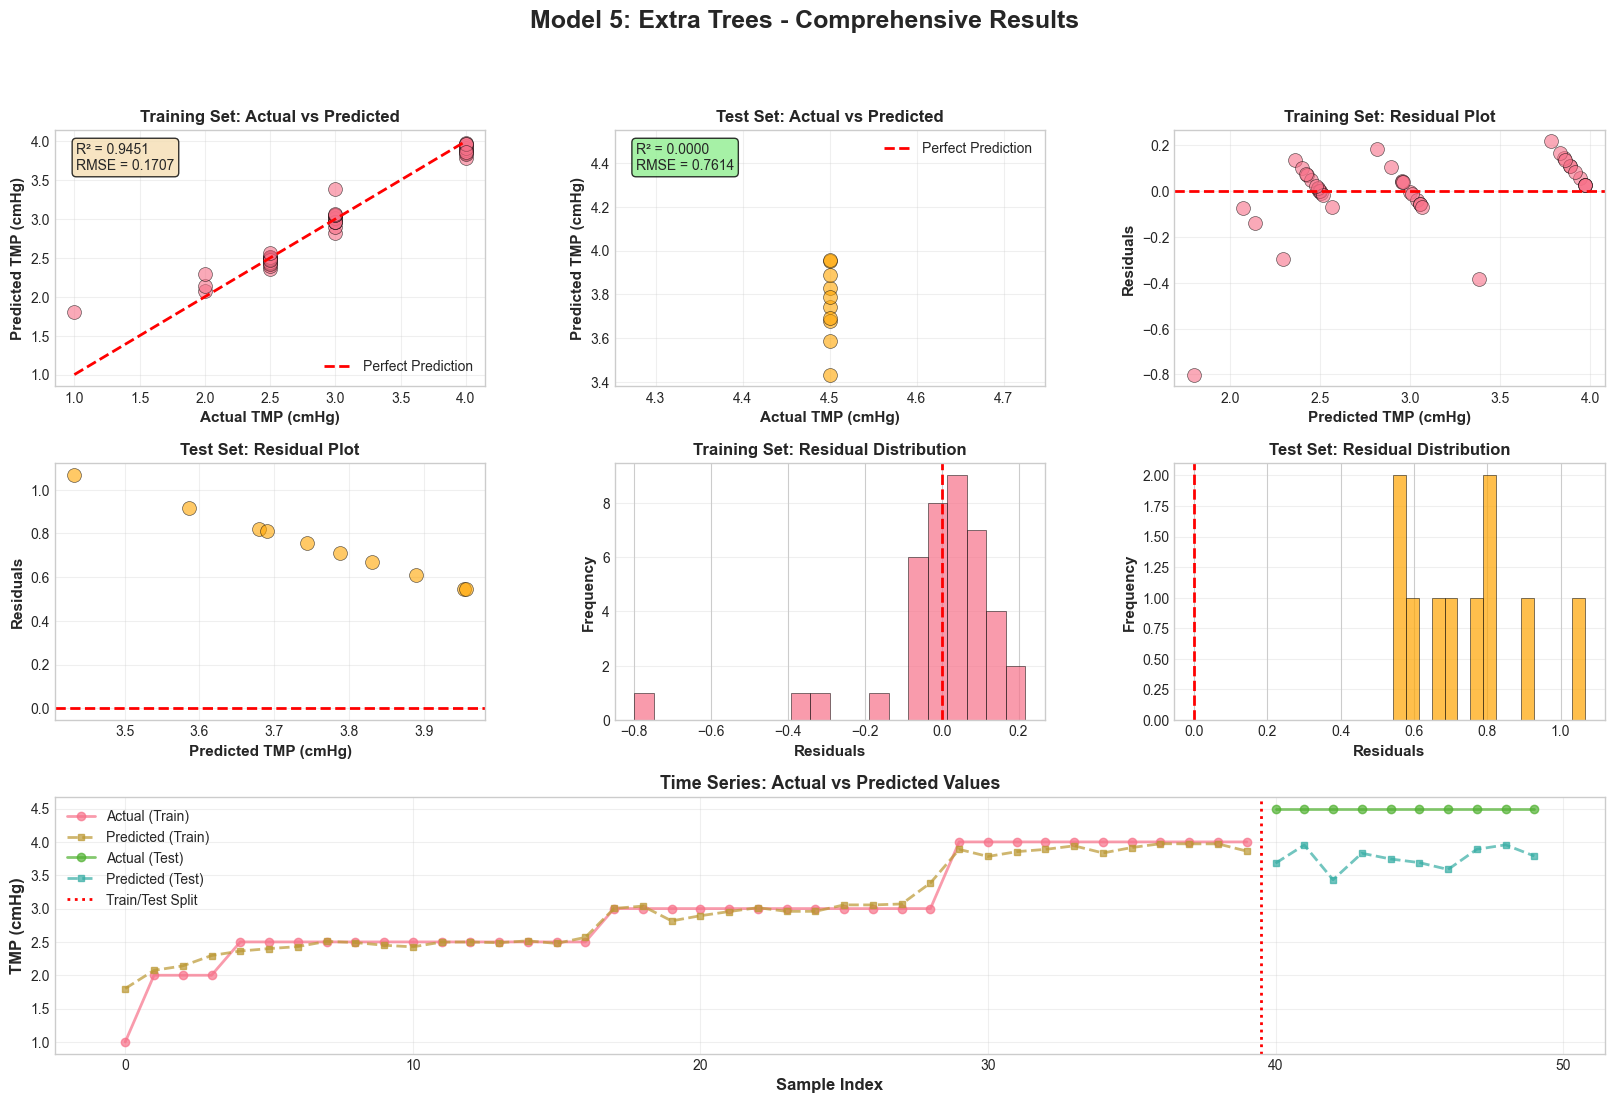

✓ Plot saved: model_05_Extra_Trees.png


In [25]:
et_model = ExtraTreesRegressor(n_estimators=200, max_depth=10,
                                min_samples_split=5, min_samples_leaf=2,
                                random_state=42, n_jobs=-1)
et_model.fit(X_train_scaled, y_train)

metrics_et, y_train_pred_et, y_test_pred_et = evaluate_model(
    et_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Extra Trees'
)

print(f"\nTrain R² Score: {metrics_et['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_et['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_et['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_et['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_et['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_et['Test_MAE']:.4f}")

all_results.append(metrics_et)

plot_model_results(y_train, y_test, y_train_pred_et, y_test_pred_et, 
                   'Extra Trees', metrics_et, 5)

### MODEL 6: XGBoost


Train R² Score: 1.0000
Test R² Score: 0.0000
Train RMSE: 0.0005
Test RMSE: 0.5762
Train MAE: 0.0004
Test MAE: 0.5421


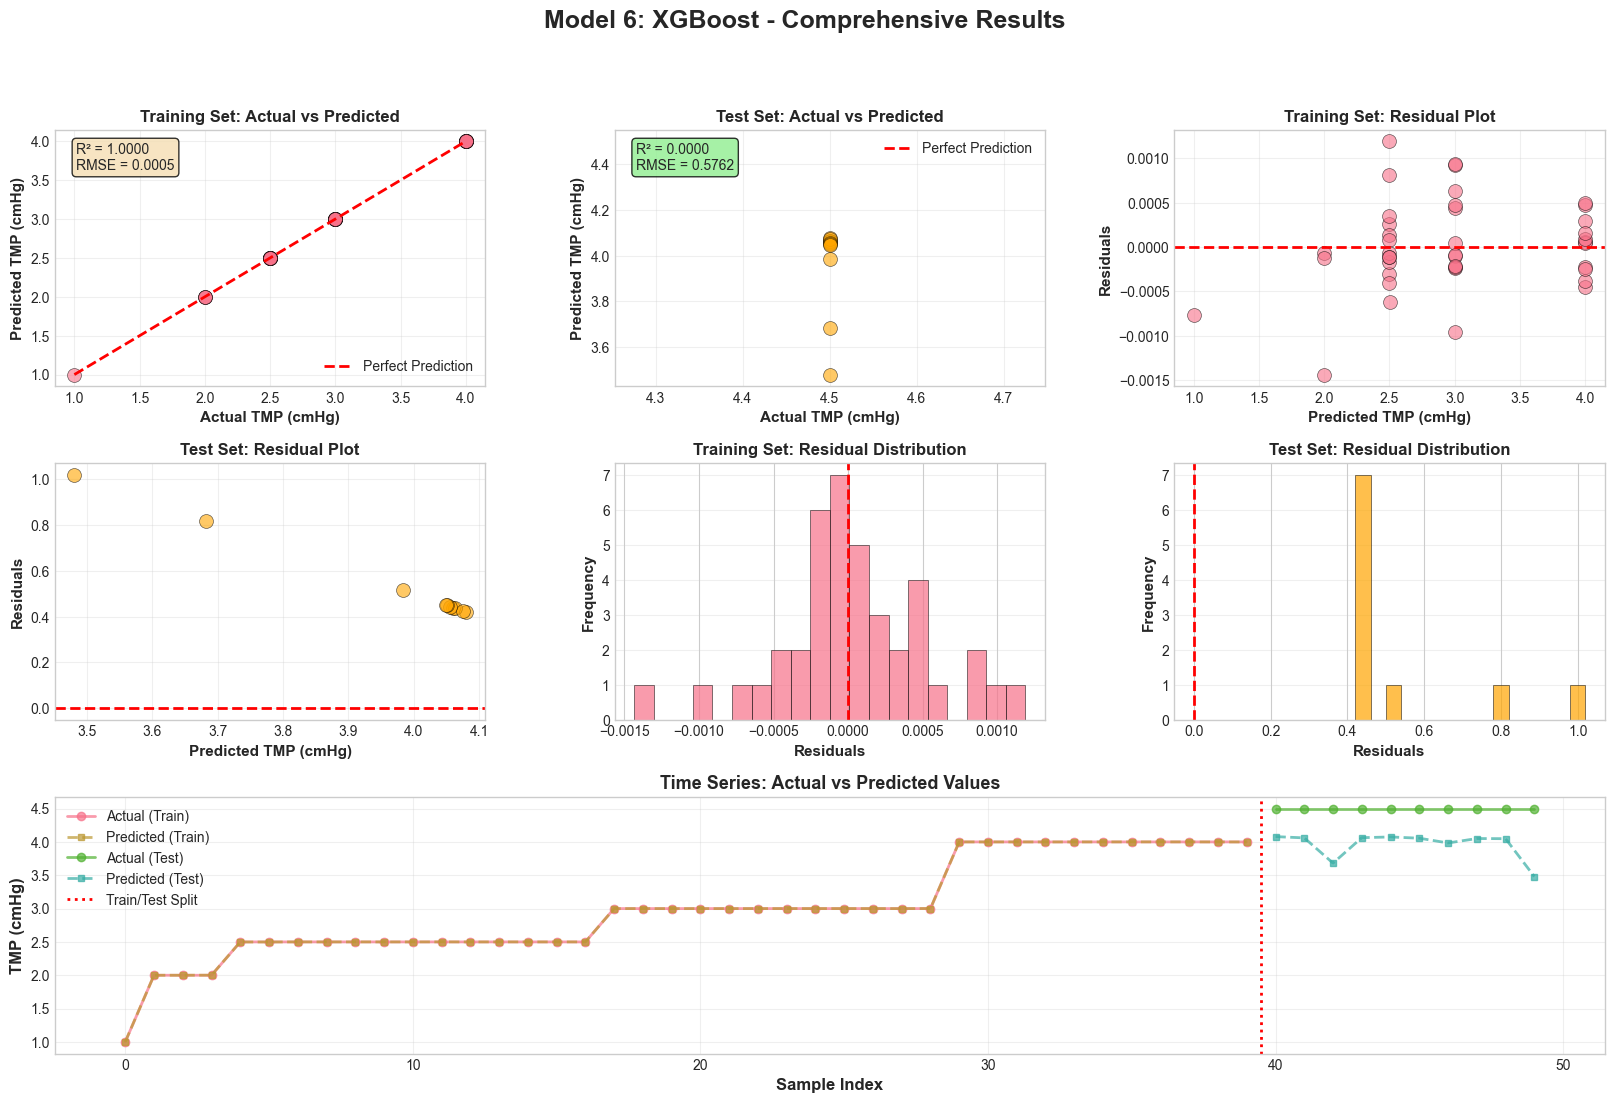

✓ Plot saved: model_06_XGBoost.png


In [26]:
xgb_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1,
                         subsample=0.8, colsample_bytree=0.8,
                         random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)

metrics_xgb, y_train_pred_xgb, y_test_pred_xgb = evaluate_model(
    xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, 'XGBoost'
)

print(f"\nTrain R² Score: {metrics_xgb['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_xgb['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_xgb['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_xgb['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_xgb['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_xgb['Test_MAE']:.4f}")

all_results.append(metrics_xgb)

plot_model_results(y_train, y_test, y_train_pred_xgb, y_test_pred_xgb, 
                   'XGBoost', metrics_xgb, 6)

### MODEL 7: LightGBM


Train R² Score: 0.0551
Test R² Score: 0.0000
Train RMSE: 0.7084
Test RMSE: 1.5211
Train MAE: 0.5691
Test MAE: 1.5125


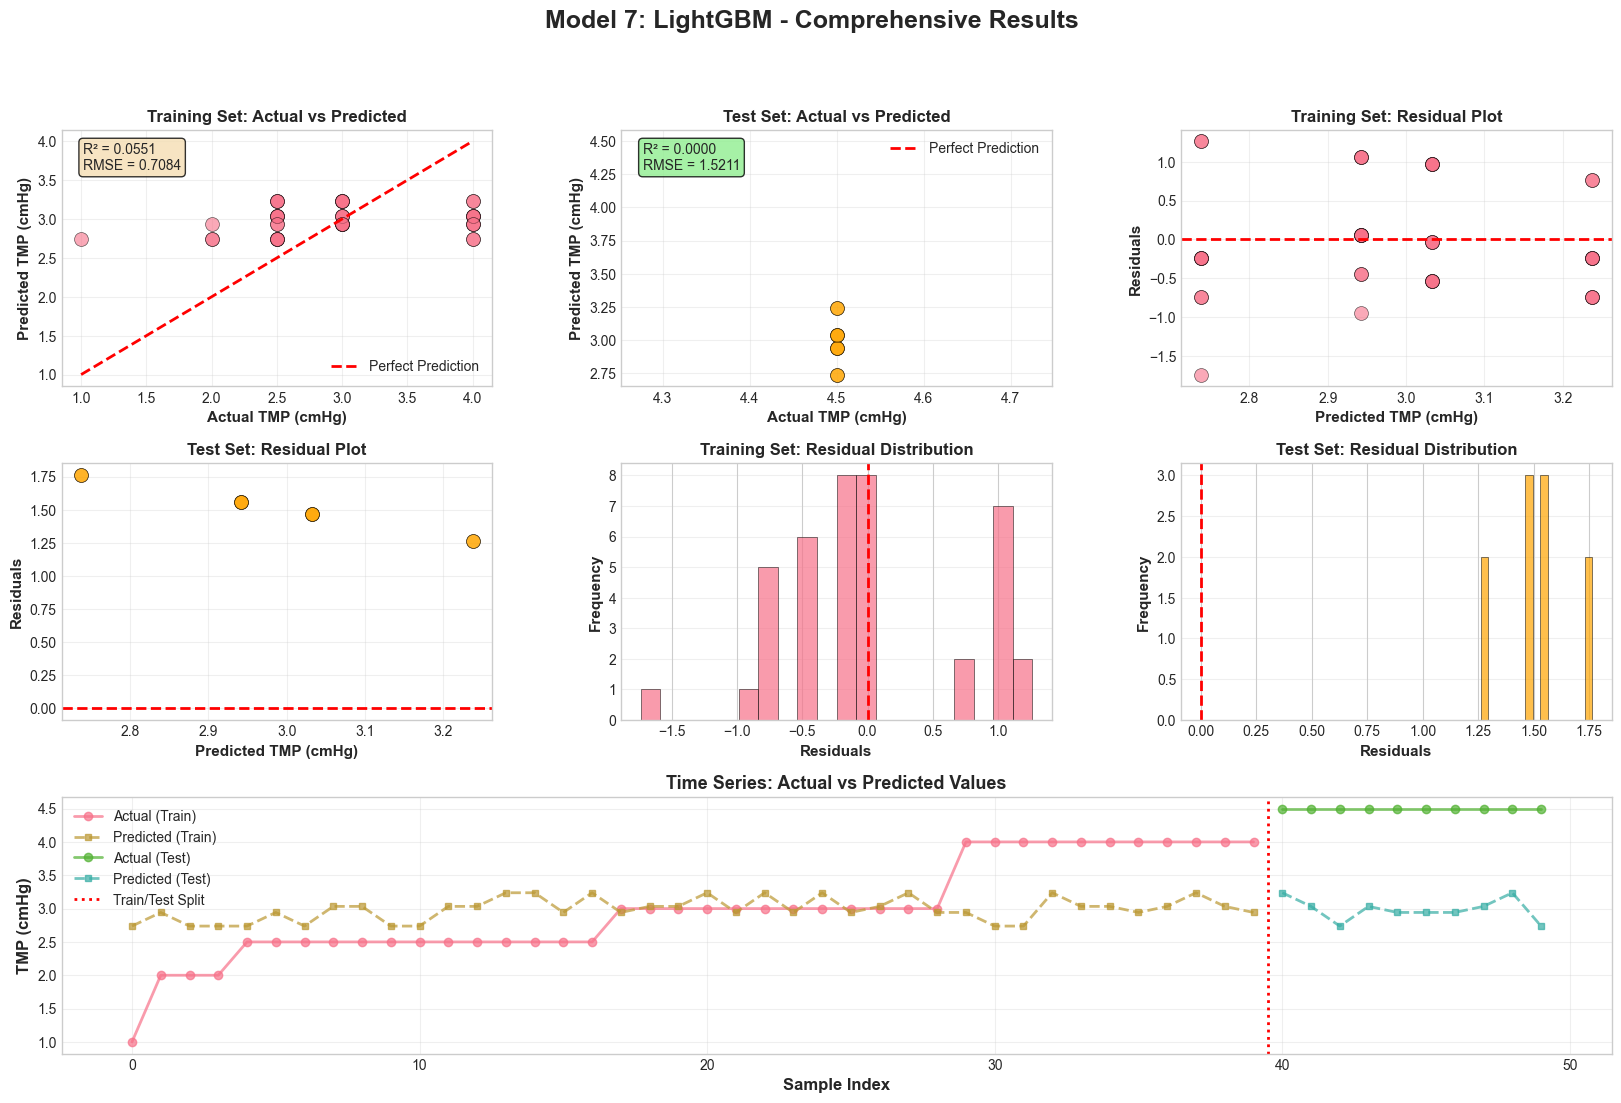

✓ Plot saved: model_07_LightGBM.png


In [27]:
lgbm_model = LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.1,
                           num_leaves=31, subsample=0.8, colsample_bytree=0.8,
                           random_state=42, n_jobs=-1, verbose=-1)
lgbm_model.fit(X_train_scaled, y_train)

metrics_lgbm, y_train_pred_lgbm, y_test_pred_lgbm = evaluate_model(
    lgbm_model, X_train_scaled, X_test_scaled, y_train, y_test, 'LightGBM'
)

print(f"\nTrain R² Score: {metrics_lgbm['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_lgbm['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_lgbm['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_lgbm['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_lgbm['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_lgbm['Test_MAE']:.4f}")

all_results.append(metrics_lgbm)

plot_model_results(y_train, y_test, y_train_pred_lgbm, y_test_pred_lgbm, 
                   'LightGBM', metrics_lgbm, 7)

### MODEL 8: CatBoost


Train R² Score: 1.0000
Test R² Score: 0.0000
Train RMSE: 0.0044
Test RMSE: 0.9257
Train MAE: 0.0034
Test MAE: 0.9142


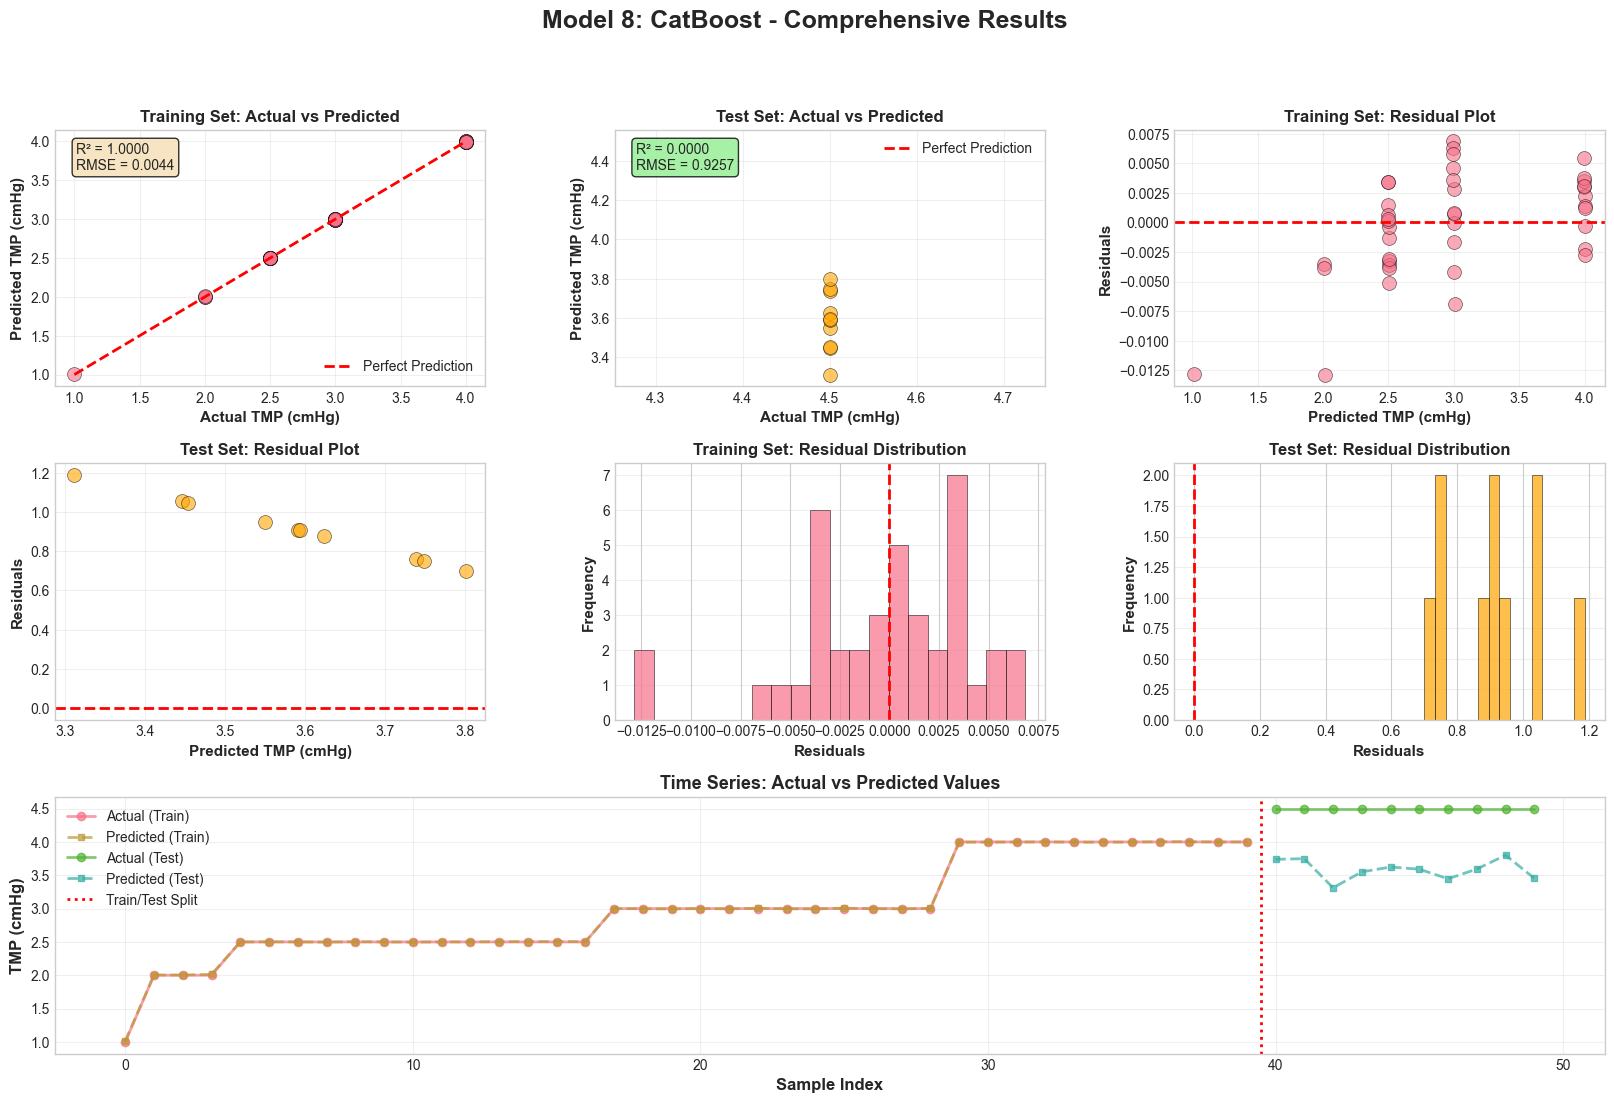

✓ Plot saved: model_08_CatBoost.png


In [28]:
catboost_model = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1,
                                   random_state=42, verbose=0)
catboost_model.fit(X_train_scaled, y_train)

metrics_catboost, y_train_pred_catboost, y_test_pred_catboost = evaluate_model(
    catboost_model, X_train_scaled, X_test_scaled, y_train, y_test, 'CatBoost'
)

print(f"\nTrain R² Score: {metrics_catboost['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_catboost['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_catboost['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_catboost['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_catboost['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_catboost['Test_MAE']:.4f}")

all_results.append(metrics_catboost)

plot_model_results(y_train, y_test, y_train_pred_catboost, y_test_pred_catboost, 
                   'CatBoost', metrics_catboost, 8)

### MODEL 9: NEURAL NETWORK


Train R² Score: 0.4060
Test R² Score: 0.0000
Train RMSE: 0.5617
Test RMSE: 1.4567
Train MAE: 0.4701
Test MAE: 1.3468


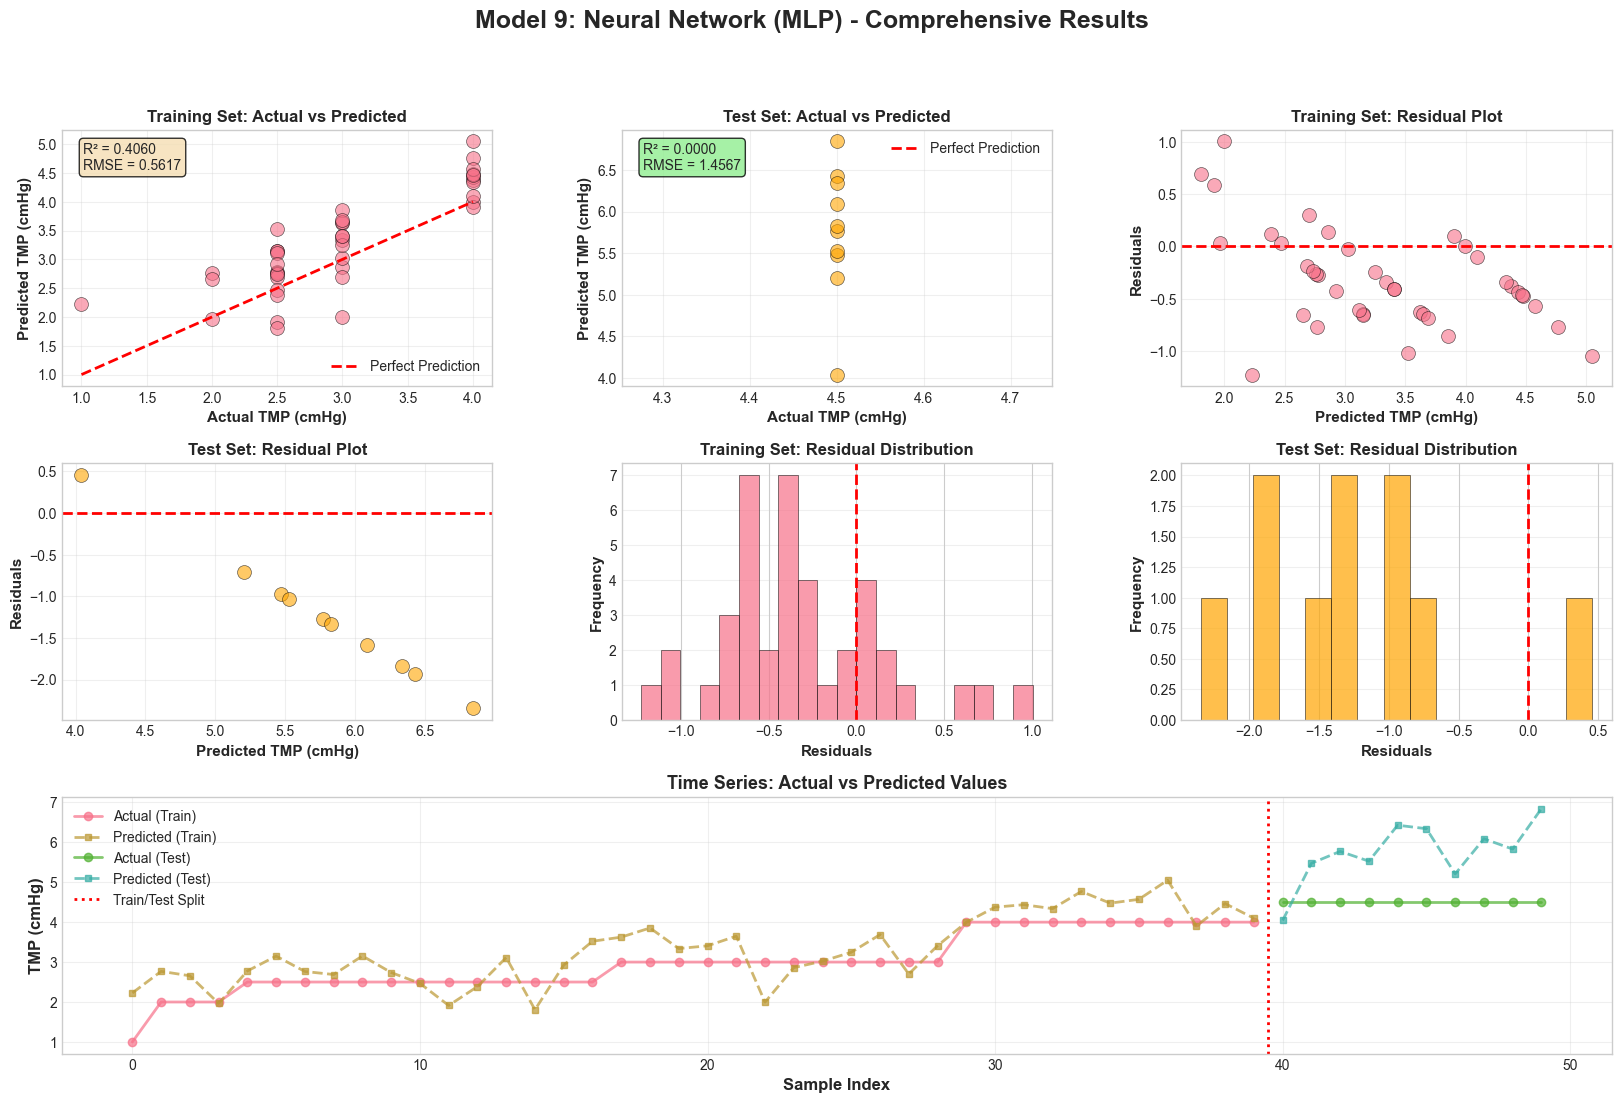

✓ Plot saved: model_09_Neural_Network_(MLP).png


In [29]:
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50, 25), 
                        activation='relu',
                        solver='adam',
                        alpha=0.001,
                        learning_rate='adaptive',
                        max_iter=1000,
                        random_state=42)
nn_model.fit(X_train_scaled, y_train)

metrics_nn, y_train_pred_nn, y_test_pred_nn = evaluate_model(
    nn_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Neural Network'
)

print(f"\nTrain R² Score: {metrics_nn['Train_R2']:.4f}")
print(f"Test R² Score: {metrics_nn['Test_R2']:.4f}")
print(f"Train RMSE: {metrics_nn['Train_RMSE']:.4f}")
print(f"Test RMSE: {metrics_nn['Test_RMSE']:.4f}")
print(f"Train MAE: {metrics_nn['Train_MAE']:.4f}")
print(f"Test MAE: {metrics_nn['Test_MAE']:.4f}")

all_results.append(metrics_nn)

plot_model_results(y_train, y_test, y_train_pred_nn, y_test_pred_nn, 
                   'Neural Network (MLP)', metrics_nn, 9)

### FINAL COMPARISON



FINAL MODEL COMPARISON

                Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE
    Linear Regression  0.807055      0.0    0.320113   0.387315   0.234913  0.312724
Polynomial Regression  0.999859      0.0    0.008653   0.740881   0.005289  0.652517
                  SVM  0.982784      0.0    0.095621   0.872894   0.094252  0.864371
        Random Forest  0.902509      0.0    0.227546   0.637970   0.148450  0.632729
          Extra Trees  0.945121      0.0    0.170721   0.761370   0.101021  0.745000
              XGBoost  1.000000      0.0    0.000508   0.576164   0.000381  0.542087
             LightGBM  0.055096      0.0    0.708401   1.521148   0.569091  1.512500
             CatBoost  0.999963      0.0    0.004434   0.925663   0.003409  0.914197
       Neural Network  0.406033      0.0    0.561651   1.456749   0.470089  1.346848


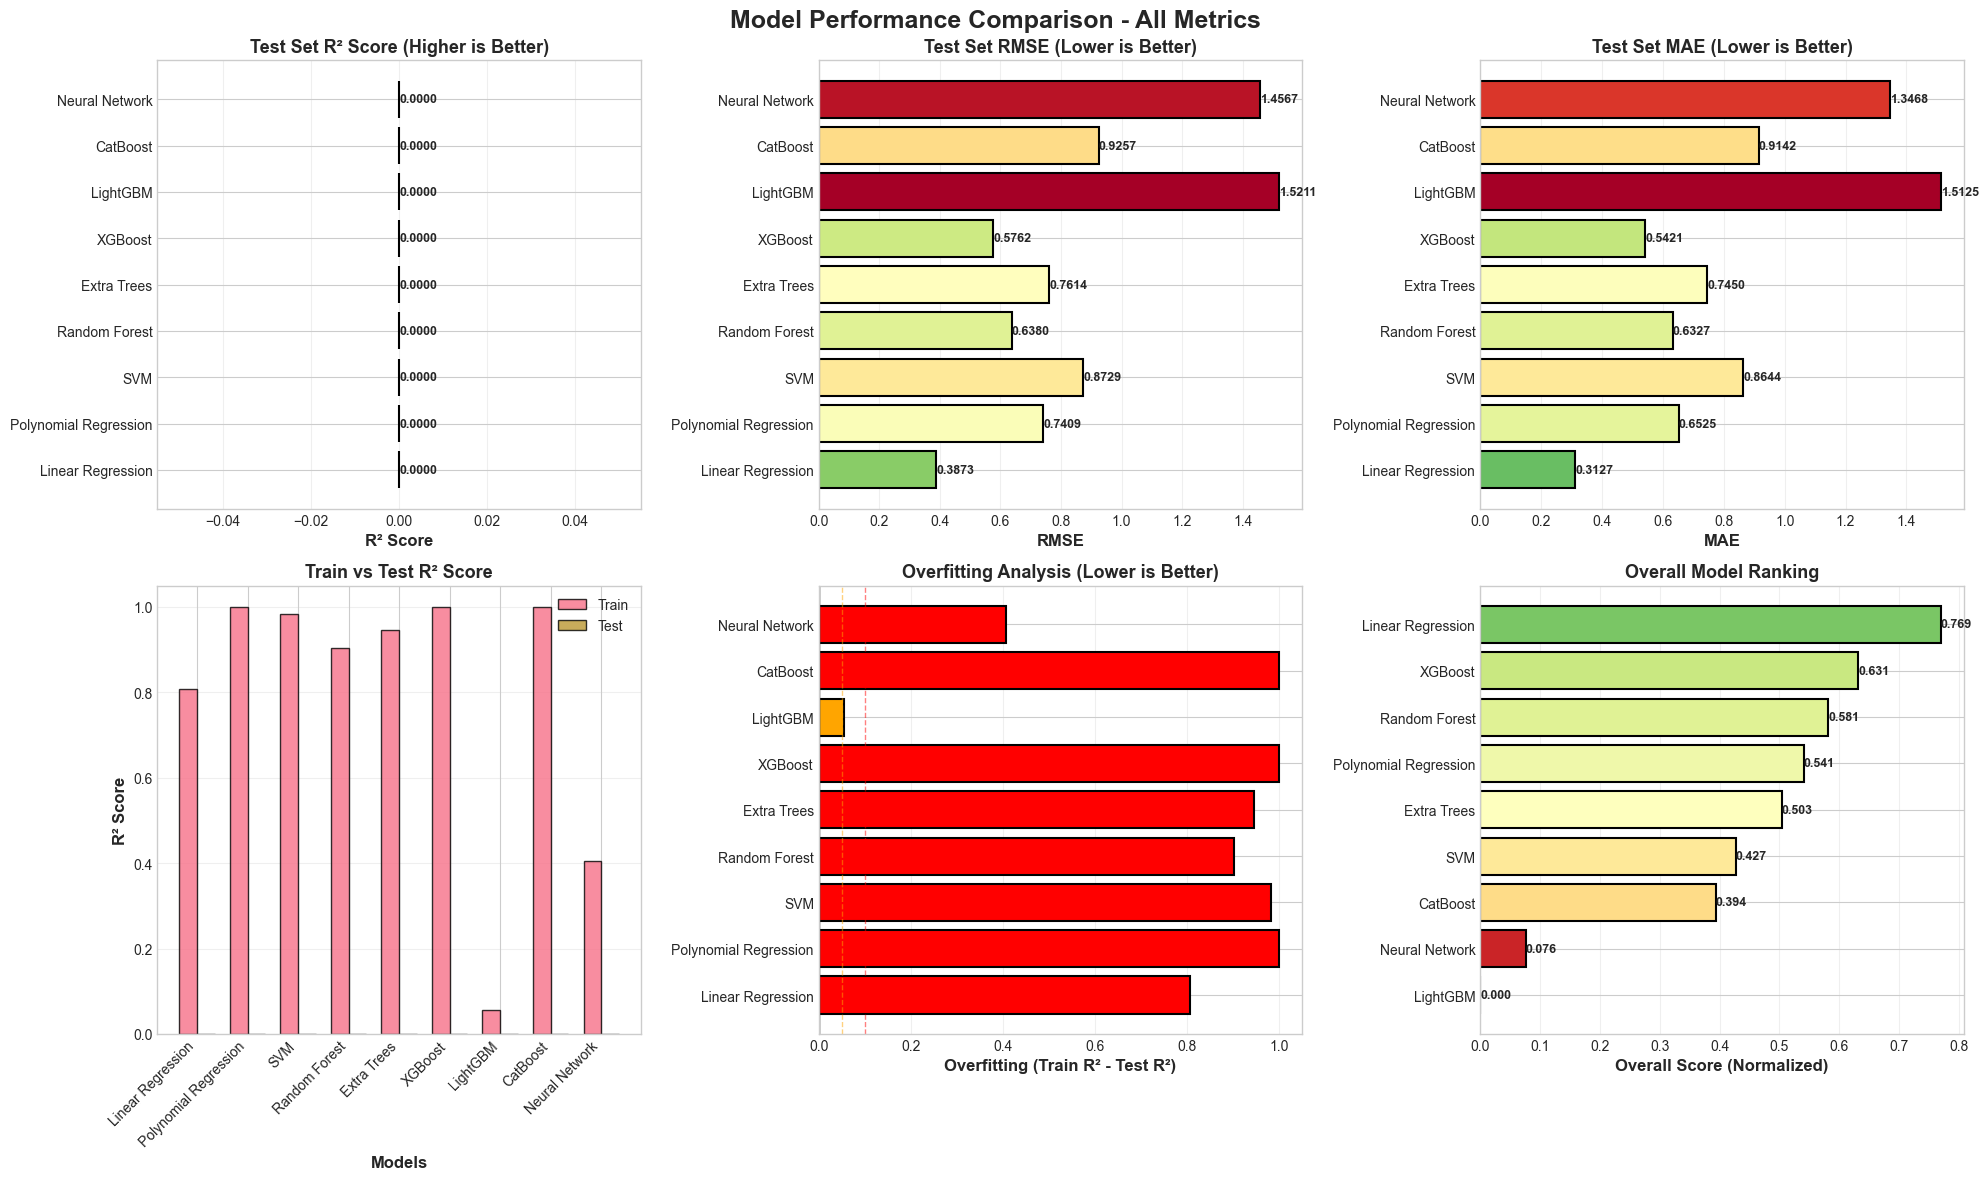

In [30]:
print("\n" + "="*100)
print("FINAL MODEL COMPARISON")
print("="*100)

results_df = pd.DataFrame(all_results)
print("\n" + results_df.to_string(index=False))

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Comparison - All Metrics', fontsize=18, fontweight='bold')

# Plot 1: Test R² Score
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn(results_df['Test_R2'].values / results_df['Test_R2'].max())
bars1 = ax1.barh(results_df['Model'], results_df['Test_R2'], color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Test Set R² Score (Higher is Better)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center', fontweight='bold', fontsize=9)

# Plot 2: Test RMSE
ax2 = axes[0, 1]
colors = plt.cm.RdYlGn_r(results_df['Test_RMSE'].values / results_df['Test_RMSE'].max())
bars2 = ax2.barh(results_df['Model'], results_df['Test_RMSE'], color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Test Set RMSE (Lower is Better)', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center', fontweight='bold', fontsize=9)

# Plot 3: Test MAE
ax3 = axes[0, 2]
colors = plt.cm.RdYlGn_r(results_df['Test_MAE'].values / results_df['Test_MAE'].max())
bars3 = ax3.barh(results_df['Model'], results_df['Test_MAE'], color=colors, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('MAE', fontsize=12, fontweight='bold')
ax3.set_title('Test Set MAE (Lower is Better)', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center', fontweight='bold', fontsize=9)

# Plot 4: Train vs Test R²
ax4 = axes[1, 0]
x = np.arange(len(results_df))
width = 0.35
bars_train = ax4.bar(x - width/2, results_df['Train_R2'], width, label='Train', alpha=0.8, edgecolor='black')
bars_test = ax4.bar(x + width/2, results_df['Test_R2'], width, label='Test', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
ax4.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax4.set_title('Train vs Test R² Score', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Plot 5: Overfitting Analysis
ax5 = axes[1, 1]
overfitting = results_df['Train_R2'] - results_df['Test_R2']
colors_over = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in overfitting]
bars5 = ax5.barh(results_df['Model'], overfitting, color=colors_over, edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Overfitting (Train R² - Test R²)', fontsize=12, fontweight='bold')
ax5.set_title('Overfitting Analysis (Lower is Better)', fontsize=13, fontweight='bold')
ax5.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax5.axvline(x=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax5.axvline(x=0.1, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax5.grid(axis='x', alpha=0.3)

# Plot 6: Overall Ranking
ax6 = axes[1, 2]
# Normalize metrics for ranking (higher is better for all)
normalized_scores = pd.DataFrame()
normalized_scores['R2'] = results_df['Test_R2'] / results_df['Test_R2'].max()
normalized_scores['RMSE'] = 1 - (results_df['Test_RMSE'] / results_df['Test_RMSE'].max())
normalized_scores['MAE'] = 1 - (results_df['Test_MAE'] / results_df['Test_MAE'].max())
normalized_scores['Overall'] = normalized_scores.mean(axis=1)

sorted_idx = normalized_scores['Overall'].sort_values(ascending=True).index
sorted_models = results_df.iloc[sorted_idx]['Model'].values
sorted_scores = normalized_scores.iloc[sorted_idx]['Overall'].values

colors_rank = plt.cm.RdYlGn(sorted_scores)
bars6 = ax6.barh(sorted_models, sorted_scores, color=colors_rank, edgecolor='black', linewidth=1.5)
ax6.set_xlabel('Overall Score (Normalized)', fontsize=12, fontweight='bold')
ax6.set_title('Overall Model Ranking', fontsize=13, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars6):
    width = bar.get_width()
    ax6.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Add ranking columns
results_df['R2_Rank'] = results_df['Test_R2'].rank(ascending=False).astype(int)
results_df['RMSE_Rank'] = results_df['Test_RMSE'].rank(ascending=True).astype(int)
results_df['MAE_Rank'] = results_df['Test_MAE'].rank(ascending=True).astype(int)
results_df['Avg_Rank'] = ((results_df['R2_Rank'] + results_df['RMSE_Rank'] + results_df['MAE_Rank']) / 3).round(2)
results_df['Overall_Rank'] = results_df['Avg_Rank'].rank(ascending=True).astype(int)

# Sort by overall rank
results_df_sorted = results_df.sort_values('Overall_Rank')

print("\n" + results_df_sorted.to_string(index=False))

# Save results to CSV
results_df_sorted.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Results saved to: model_comparison_results.csv")


                Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  R2_Rank  RMSE_Rank  MAE_Rank  Avg_Rank  Overall_Rank
    Linear Regression  0.807055      0.0    0.320113   0.387315   0.234913  0.312724        5          1         1      2.33             1
              XGBoost  1.000000      0.0    0.000508   0.576164   0.000381  0.542087        5          2         2      3.00             2
        Random Forest  0.902509      0.0    0.227546   0.637970   0.148450  0.632729        5          3         3      3.67             3
Polynomial Regression  0.999859      0.0    0.008653   0.740881   0.005289  0.652517        5          4         4      4.33             4
          Extra Trees  0.945121      0.0    0.170721   0.761370   0.101021  0.745000        5          5         5      5.00             5
                  SVM  0.982784      0.0    0.095621   0.872894   0.094252  0.864371        5          6         6      5.67             6
             CatBoost  0.9

### ENSEMBLE PREDICTION PLOT

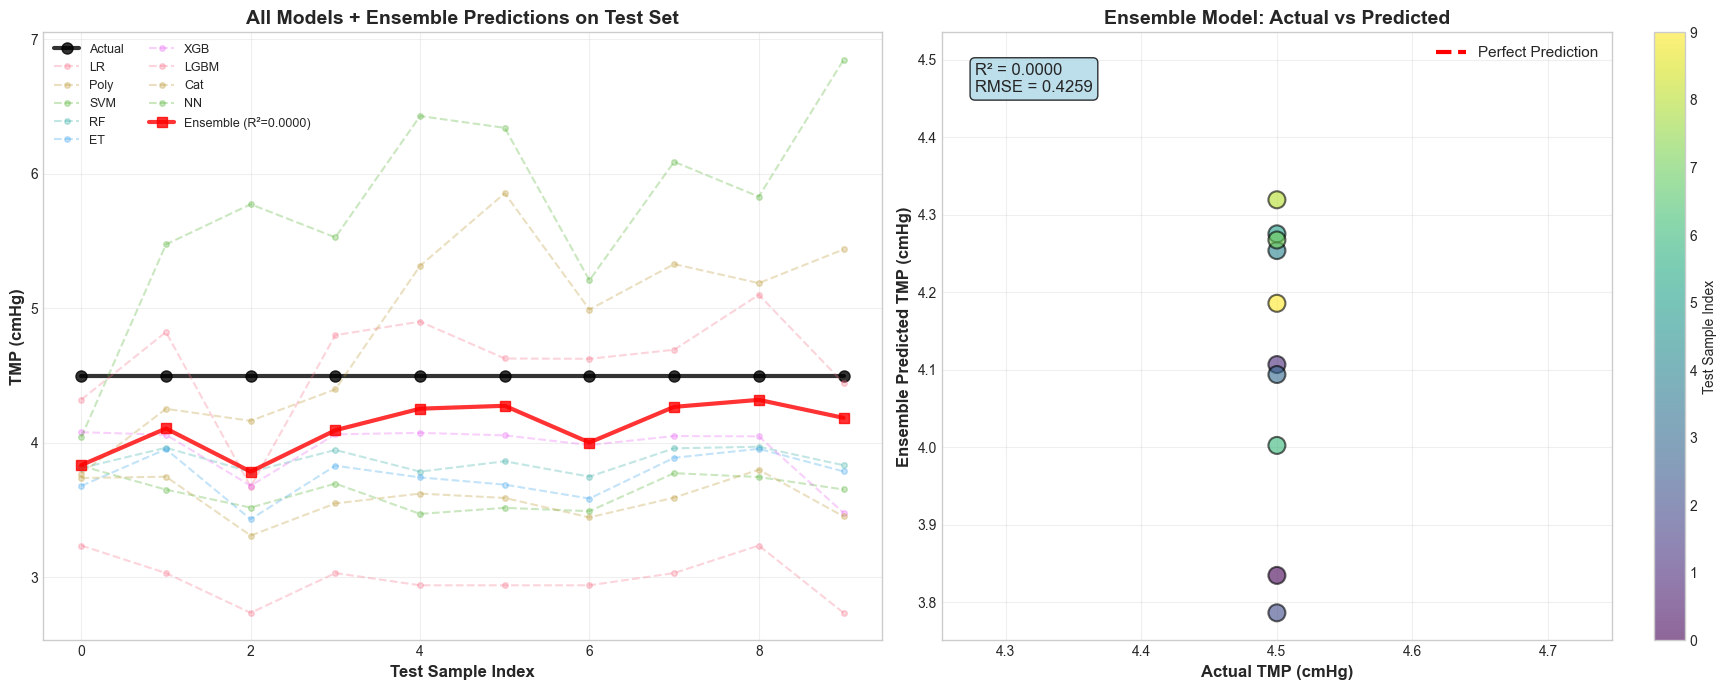


✓ Ensemble Performance:
   R² Score: 0.0000
   RMSE: 0.4259
   MAE: 0.3872


In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Collect all test predictions
all_test_preds = np.column_stack([
    y_test_pred_lr, y_test_pred_poly, y_test_pred_svm,
    y_test_pred_rf, y_test_pred_et, y_test_pred_xgb,
    y_test_pred_lgbm, y_test_pred_catboost, y_test_pred_nn
])

# Simple average ensemble
ensemble_pred = all_test_preds.mean(axis=1)
ensemble_r2 = r2_score(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

# Plot 1: All models + Ensemble
test_indices = range(len(y_test))
ax1.plot(test_indices, y_test.values, 'ko-', label='Actual', linewidth=3, markersize=8, alpha=0.8)

model_names_short = ['LR', 'Poly', 'SVM', 'RF', 'ET', 'XGB', 'LGBM', 'Cat', 'NN']
alphas = [0.3] * 9

for i, (pred, name) in enumerate(zip(all_test_preds.T, model_names_short)):
    ax1.plot(test_indices, pred, 'o--', label=name, alpha=alphas[i], markersize=4)

ax1.plot(test_indices, ensemble_pred, 's-', label=f'Ensemble (R²={ensemble_r2:.4f})', 
         linewidth=3, markersize=7, color='red', alpha=0.8)

ax1.set_xlabel('Test Sample Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('TMP (cmHg)', fontsize=12, fontweight='bold')
ax1.set_title('All Models + Ensemble Predictions on Test Set', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', ncol=2, fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Ensemble vs Actual
ax2.scatter(y_test, ensemble_pred, s=150, alpha=0.6, edgecolors='black', linewidth=1.5, c=test_indices, cmap='viridis')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Perfect Prediction')
ax2.set_xlabel('Actual TMP (cmHg)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Ensemble Predicted TMP (cmHg)', fontsize=12, fontweight='bold')
ax2.set_title('Ensemble Model: Actual vs Predicted', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.text(0.05, 0.95, f"R² = {ensemble_r2:.4f}\nRMSE = {ensemble_rmse:.4f}", 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontsize=12)

cbar = plt.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label('Test Sample Index', fontsize=10)

plt.tight_layout()
plt.savefig('model_ensemble_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Ensemble Performance:")
print(f"   R² Score: {ensemble_r2:.4f}")
print(f"   RMSE: {ensemble_rmse:.4f}")
print(f"   MAE: {mean_absolute_error(y_test, ensemble_pred):.4f}")